In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [2]:
train=pd.read_csv("training_LSTM.csv")
test=pd.read_csv("testing_LSTM.csv")

In [4]:
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
test['Date'] = pd.to_datetime(test['Date'])
train['Date'] = pd.to_datetime(train['Date'])

In [5]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])


## TIME EVALUATION

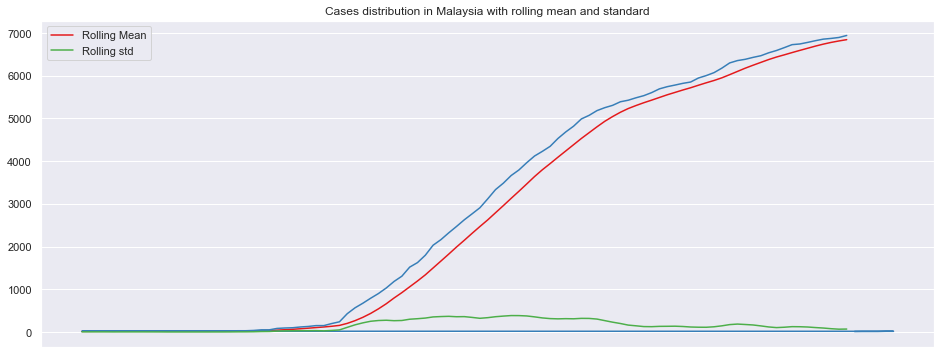

In [7]:
tsC1=roll('Malaysia')
rollPlot('Malaysia')

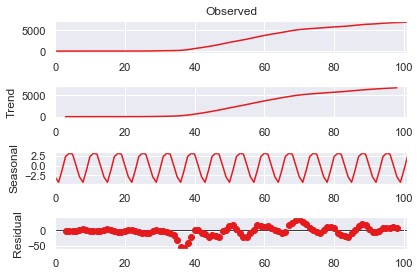

In [8]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC1.values,freq=7).plot()

In [11]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For Malaysia
tsC=tsC1['ConfirmedCases'].values
stationarity(tsC)

Results of Dickey-Fuller Test:
Test Statistic                 -0.765811
p-value                         0.828959
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


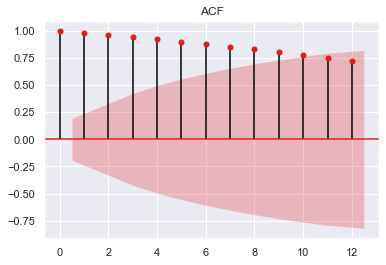

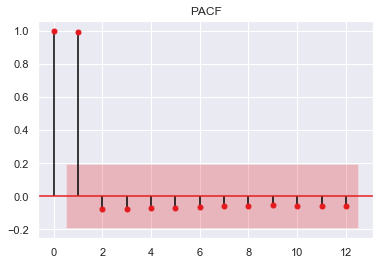

In [12]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

#For Malaysia
corr(tsC1)

In [13]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [14]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [17]:
train_features=pd.DataFrame(create_features(train))
test_features=pd.DataFrame(create_features(test))
features_and_target_train = pd.concat([train,train_features], axis=1)
features_and_target_test = pd.concat([test,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [19]:
x_train= features_and_target_train[['Country_Region','month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
y1 = features_and_target_train[['ConfirmedCases']]
y2 =features_and_target_train[['Fatalities']]
x_test = features_and_target_test[['Country_Region', 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   84
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -298.514
Method:                       css-mle   S.D. of innovations              7.985
Date:                Fri, 21 Aug 2020   AIC                            609.028
Time:                        16:17:02   BIC                            623.613
Sample:                             2   HQIC                           614.891
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9184      1.619      0.567      0.570      -2.254       4.091
ma.L1.D2.y     0.4501      0.094      4.770      0.000       0.265       0.635
ma.L2.D2.y     0.4614      0.105      4.395      0.0

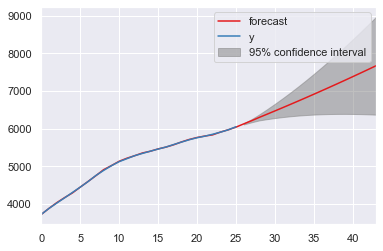

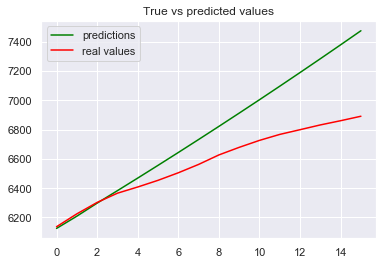

In [20]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)

#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)

train,test=split(tsC)
pred=arima(train,test)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   84
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -298.514
Method:                       css-mle   S.D. of innovations              7.985
Date:                Fri, 21 Aug 2020   AIC                            609.028
Time:                        16:18:41   BIC                            623.613
Sample:                             2   HQIC                           614.891
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9184      1.619      0.567      0.570      -2.254       4.091
ma.L1.D2.y     0.4501      0.094      4.770      0.000       0.265       0.635
ma.L2.D2.y     0.4614      0.105      4.395      0.0

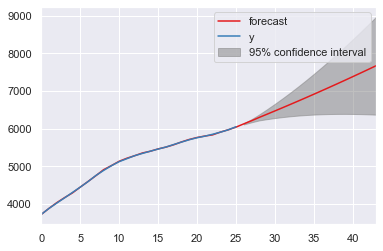

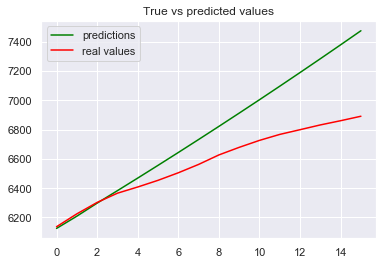

In [21]:
#Mean absolute percentage error
def mape(y2, y_pred): 
    y2, y_pred = np.array(y2), np.array(y_pred)
    return np.mean(np.abs((y2 - y_pred) / y2)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
               #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsC)
pred=arima(train,test)
            
            